In [10]:
import yfinance as yf

# Baixar dados históricos do Ibovespa dos últimos 5 anos
ibovespa = yf.download('^BVSP', period="5y")

# Exibir os primeiros 5 registros
print(ibovespa.head())

[*********************100%***********************]  1 of 1 completed

Price      Adj Close     Close      High       Low      Open   Volume
Ticker         ^BVSP     ^BVSP     ^BVSP     ^BVSP     ^BVSP    ^BVSP
Date                                                                 
2020-01-06  116878.0  116878.0  117707.0  116269.0  117707.0  6570000
2020-01-07  116662.0  116662.0  117076.0  115965.0  116872.0  4854100
2020-01-08  116247.0  116247.0  117335.0  115693.0  116667.0  5910500
2020-01-09  115947.0  115947.0  116820.0  115411.0  116248.0  5953500
2020-01-10  115503.0  115503.0  116745.0  114952.0  115948.0  4783400


In [11]:
# Baixar dados históricos da ação MGLU3 dos últimos 5 anos
mglu3 = yf.download('CMIN3.SA', period="5y")

# Exibir os primeiros 5 registros
print(mglu3.head())


[*********************100%***********************]  1 of 1 completed

Price      Adj Close    Close     High      Low     Open    Volume
Ticker      CMIN3.SA CMIN3.SA CMIN3.SA CMIN3.SA CMIN3.SA  CMIN3.SA
Date                                                              
2021-02-22  5.925878     9.29     9.30     8.67     8.92  10507000
2021-02-23  5.817439     9.12     9.60     9.10     9.50   9243700
2021-02-24  5.836574     9.15     9.28     9.07     9.16   6550600
2021-02-25  5.772787     9.05     9.29     9.00     9.18   6054200
2021-02-26  5.696243     8.93     9.17     8.90     9.15   4849000


In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Selecionar apenas o preço de fechamento ajustado
mglu3_close = mglu3['Adj Close'].dropna()

# Criar um DataFrame com os valores ajustados
data = pd.DataFrame(mglu3_close)
data.columns = ['Close']

# Normalizar os dados para usar no modelo
scaler = MinMaxScaler(feature_range=(0, 1))
data['Scaled_Close'] = scaler.fit_transform(data[['Close']])

print(data.head())


               Close  Scaled_Close
Date                              
2021-02-22  5.925878      0.668598
2021-02-23  5.817439      0.648110
2021-02-24  5.836574      0.651725
2021-02-25  5.772787      0.639673
2021-02-26  5.696243      0.625211


In [13]:
# Função para criar janelas de dados
def create_dataset(data, window_size=60):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

# Criar conjuntos de dados
window_size = 60
scaled_data = data['Scaled_Close'].values
X, y = create_dataset(scaled_data, window_size)

# Dividir em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print("Formato dos dados:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)


Formato dos dados:
X_train: (725, 60) y_train: (725,)
X_test: (182, 60) y_test: (182,)


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Criar o modelo LSTM
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compilar o modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Ajustar o formato de entrada
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Treinar o modelo
model.fit(X_train, y_train, epochs=20, batch_size=32)


c:\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 0.1045
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0076
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0052
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0040
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0043
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0044
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0035
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0038
Epoch 9/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0040
Epoch 10/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0033
Epoch 11/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0032
Epoch 12/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0032
Epoch 13/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0030
Epoch 14/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0028
Epoch 15/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0031
Epoc

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step
Erro Quadrático Médio (MSE): 0.10634611649040684


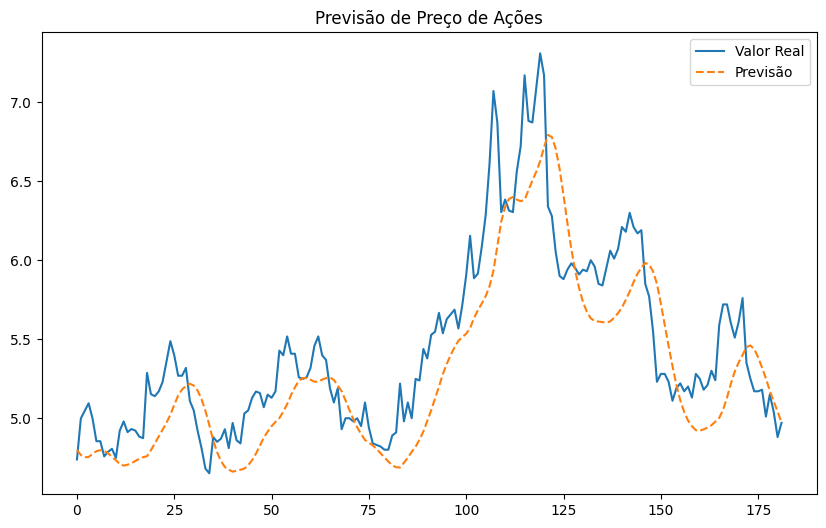

In [15]:
# Fazer previsões
predictions = model.predict(X_test)

# Inverter a normalização
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Avaliar o modelo
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

mse = mean_squared_error(y_test, predictions)
print("Erro Quadrático Médio (MSE):", mse)

# Gráfico com resultados
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Valor Real')
plt.plot(predictions, label='Previsão', linestyle='dashed')
plt.legend()
plt.title('Previsão de Preço de Ações')
plt.show()
